In [32]:
# Cell 1: Imports and Initial Setup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import datetime
import statsmodels.api as sm
import statsmodels.tsa.stattools as ts

# Display options
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')


In [33]:
# Cell 2: Fetch data from yfinance
import yfinance as yf

tickers = ['^GSPC', '^NDX', 'GC=F', 'HG=F', 'CL=F', 'NG=F', 'LE=F', 'JPY=X', 'EURUSD=X', 'DX-Y.NYB']
data = yf.download(tickers, start="2010-01-01", end="2025-03-01")['Close']

data = data.rename(columns={
    '^GSPC': 'SP500',
    '^NDX': 'NASDAQ100',
    'GC=F': 'Gold',
    'HG=F': 'Copper',
    'CL=F': 'CrudeOil',
    'NG=F': 'NaturalGas',
    'LE=F': 'LiveCattle',
    'JPY=X': 'USDJPY',
    'EURUSD=X': 'EURUSD',
    'DX-Y.NYB': 'USDIndex'
})

# Drop NaNs
data = data.dropna()

data.head()
data = data.dropna()

data.head()


[*********************100%***********************]  10 of 10 completed


Ticker,CrudeOil,USDIndex,EURUSD,Gold,Copper,USDJPY,LiveCattle,NaturalGas,SP500,NASDAQ100
Date,,,,,,,,,,
2010-01-04,81.510002,77.529999,1.442398,1117.699951,3.3880,92.495003,85.375000,5.884,1132.989990,1886.699951
2010-01-05,81.769997,77.620003,1.436596,1118.099976,3.3960,91.584999,86.324997,5.637,1136.520020,1888.430054
2010-01-06,83.180000,77.489998,1.440403,1135.900024,3.4775,92.356003,85.949997,6.009,1137.140015,1878.420044
2010-01-07,82.660004,77.910004,1.431803,1133.099976,3.4115,93.389999,85.925003,5.806,1141.689941,1876.719971
2010-01-08,82.750000,77.470001,1.441109,1138.199951,3.3880,92.660004,85.824997,5.749,1144.979980,1892.589966


In [34]:
# Cell 3: Data Exploration & Cleaning
data = data.ffill().dropna()

data.head()
data.describe()


Ticker,CrudeOil,USDIndex,EURUSD,Gold,Copper,USDJPY,LiveCattle,NaturalGas,SP500,NASDAQ100
count,3802.000000,3802.000000,3802.000000,3802.000000,3802.000000,3802.000000,3802.000000,3802.000000,3802.000000,3802.000000
mean,71.992998,92.374627,1.188512,1558.164202,3.329541,110.618149,130.679491,3.368829,2764.034047,7749.282364
std,21.243970,9.471594,0.114412,372.355983,0.695525,20.488903,25.954606,1.258854,1301.920718,5386.794727
min,-37.630001,72.930000,0.959619,1050.800049,1.939500,75.739998,83.824997,1.482000,1022.580017,1728.339966
25%,53.400002,82.222502,1.096927,1262.099976,2.757125,100.225000,112.875000,2.589250,1742.542511,3327.569946
50%,72.985001,94.584999,1.153090,1461.500000,3.273500,109.366501,123.612499,2.985000,2445.270020,5880.834961
75%,89.272499,98.989998,1.293377,1792.275024,3.848000,119.419502,144.199997,3.941000,3856.057556,12032.729980
max,123.699997,114.110001,1.484406,2947.899902,5.119000,161.606995,208.550003,9.680000,6144.149902,22175.599609


In [35]:
# Cell 3: Integrating FRED Economic Data
from fredapi import Fred
import pandas as pd

# Insert your own API Key from FRED clearly here
fred = Fred(api_key='04e837bfc107e4622a89bb7acf50bca5')

fred_series = {
    '10Y_Treasury_Yield': 'DGS10',
    '2Y10Y_Spread': 'T10Y2Y',
    'CPI': 'CPIAUCSL',
    'PPI': 'PPIACO',
    'Unemployment_Rate': 'UNRATE',
    'US_Federal_Funds_Rate': 'FEDFUNDS',
    'Consumer_Price_Index': 'CPIAUCSL',
    'Consumer_Sentiment': 'UMCSENT'
}

# Fetch data from FRED API
macro_data = pd.DataFrame({name: fred.get_series(series) for name, series in fred_series.items()})

# Set DateTime index clearly
macro_data.index = pd.to_datetime(macro_data.index)

# Align macroeconomic data dates with market data clearly
macro_data = macro_data.loc['2010-01-01':'2024-03-01'].ffill().dropna()

macro_data.head()


,10Y_Treasury_Yield,2Y10Y_Spread,CPI,PPI,Unemployment_Rate,US_Federal_Funds_Rate,Consumer_Price_Index,Consumer_Sentiment
2010-01-04,3.85,2.76,217.488,181.9,9.8,0.11,217.488,74.4
2010-01-05,3.77,2.76,217.488,181.9,9.8,0.11,217.488,74.4
2010-01-06,3.85,2.84,217.488,181.9,9.8,0.11,217.488,74.4
2010-01-07,3.85,2.82,217.488,181.9,9.8,0.11,217.488,74.4
2010-01-08,3.83,2.87,217.488,181.9,9.8,0.11,217.488,74.4


In [36]:
# Cell 3: Merge returns data and macroeconomic data clearly
data = pd.merge(data, macro_data, left_index=True, right_index=True, how='inner')

data.head()


,CrudeOil,USDIndex,EURUSD,Gold,Copper,USDJPY,LiveCattle,NaturalGas,SP500,NASDAQ100,10Y_Treasury_Yield,2Y10Y_Spread,CPI,PPI,Unemployment_Rate,US_Federal_Funds_Rate,Consumer_Price_Index,Consumer_Sentiment
2010-01-04,81.510002,77.529999,1.442398,1117.699951,3.3880,92.495003,85.375000,5.884,1132.989990,1886.699951,3.85,2.76,217.488,181.9,9.8,0.11,217.488,74.4
2010-01-05,81.769997,77.620003,1.436596,1118.099976,3.3960,91.584999,86.324997,5.637,1136.520020,1888.430054,3.77,2.76,217.488,181.9,9.8,0.11,217.488,74.4
2010-01-06,83.180000,77.489998,1.440403,1135.900024,3.4775,92.356003,85.949997,6.009,1137.140015,1878.420044,3.85,2.84,217.488,181.9,9.8,0.11,217.488,74.4
2010-01-07,82.660004,77.910004,1.431803,1133.099976,3.4115,93.389999,85.925003,5.806,1141.689941,1876.719971,3.85,2.82,217.488,181.9,9.8,0.11,217.488,74.4
2010-01-08,82.750000,77.470001,1.441109,1138.199951,3.3880,92.660004,85.824997,5.749,1144.979980,1892.589966,3.83,2.87,217.488,181.9,9.8,0.11,217.488,74.4


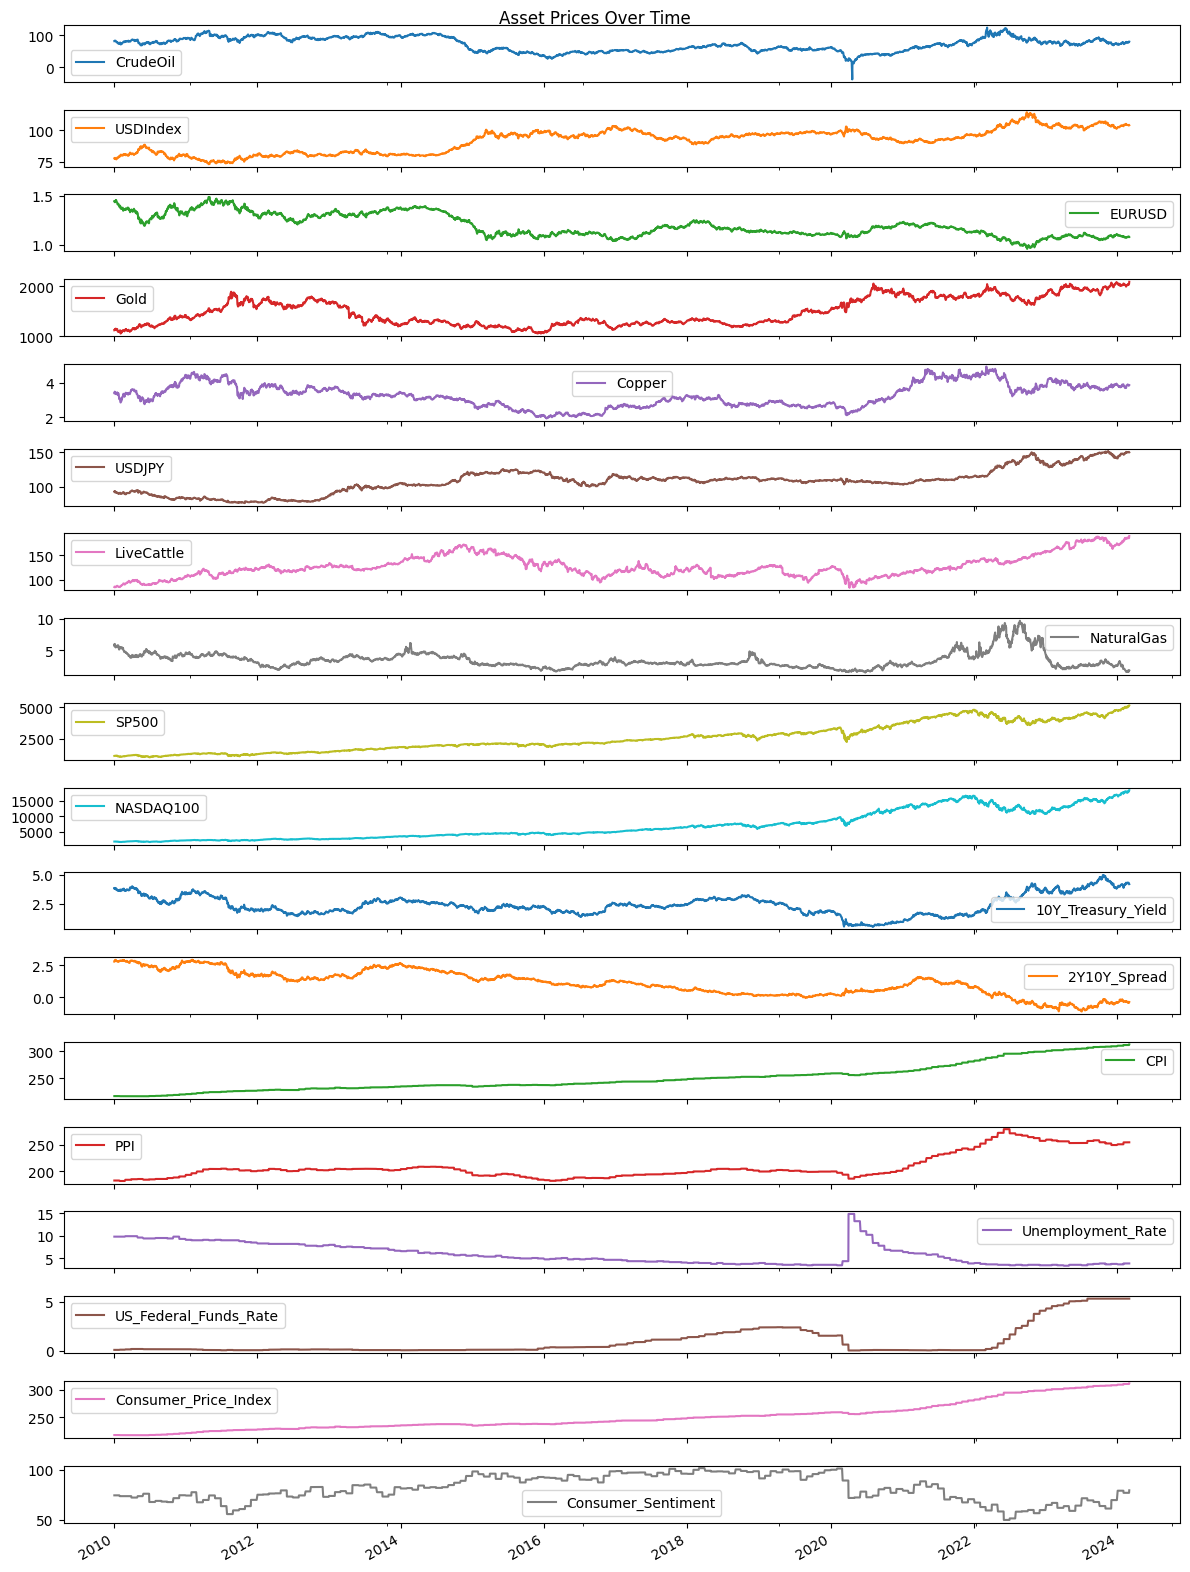

In [37]:
# Cell 4: Price Movement Visualization
import matplotlib.pyplot as plt

data.plot(subplots=True, figsize=(12, 16), title="Asset Prices Over Time")
plt.tight_layout()
plt.show()


In [38]:
# Cell 5: Calculate Daily Returns
returns = data.pct_change().dropna()
returns.head()


,CrudeOil,USDIndex,EURUSD,Gold,Copper,USDJPY,LiveCattle,NaturalGas,SP500,NASDAQ100,10Y_Treasury_Yield,2Y10Y_Spread,CPI,PPI,Unemployment_Rate,US_Federal_Funds_Rate,Consumer_Price_Index,Consumer_Sentiment
2010-01-05,0.003190,0.001161,-0.004022,0.000358,0.002361,-0.009838,0.011127,-0.041978,0.003116,0.000917,-0.020779,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2010-01-06,0.017244,-0.001675,0.002650,0.015920,0.023999,0.008418,-0.004344,0.065993,0.000546,-0.005301,0.021220,0.028986,0.0,0.0,0.0,0.0,0.0,0.0
2010-01-07,-0.006251,0.005420,-0.005971,-0.002465,-0.018979,0.011196,-0.000291,-0.033783,0.004001,-0.000905,0.000000,-0.007042,0.0,0.0,0.0,0.0,0.0,0.0
2010-01-08,0.001089,-0.005648,0.006499,0.004501,-0.006888,-0.007817,-0.001164,-0.009817,0.002882,0.008456,-0.005195,0.017730,0.0,0.0,0.0,0.0,0.0,0.0
2010-01-11,-0.002779,-0.006067,0.006951,0.010982,0.011954,-0.006130,-0.009030,-0.051313,0.001747,-0.003355,0.005222,0.010453,0.0,0.0,0.0,0.0,0.0,0.0


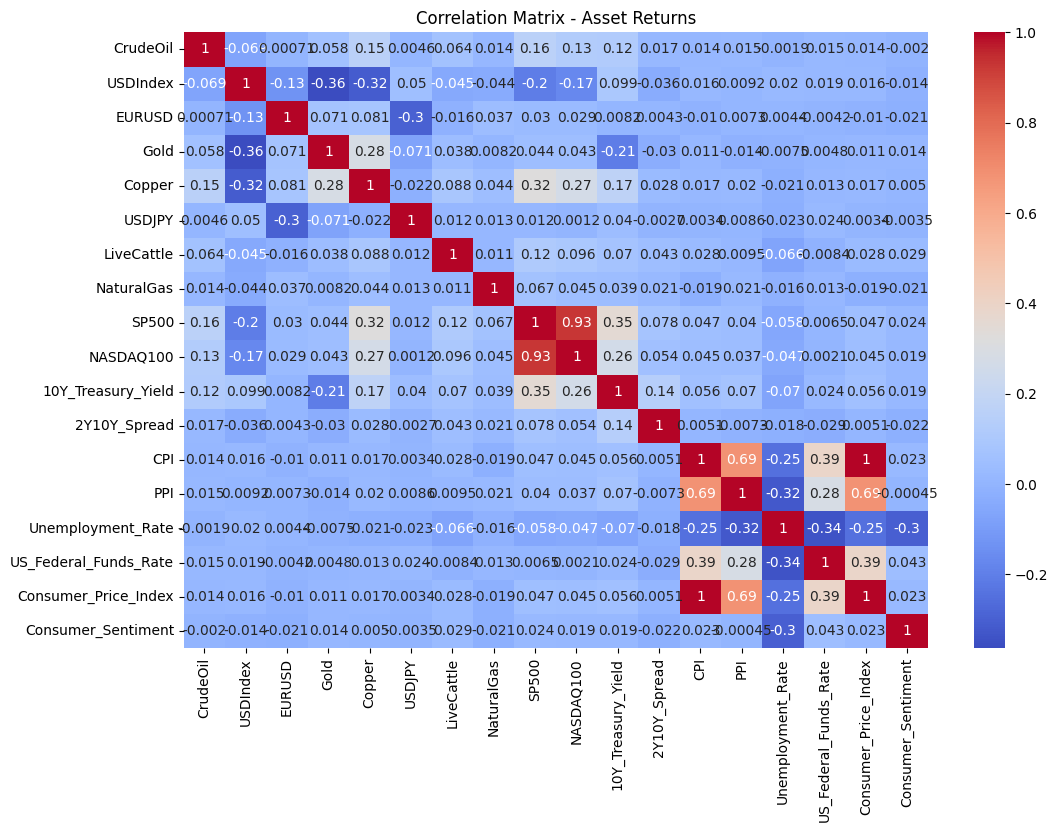

In [39]:
# Cell 5: Correlation Matrix & Heatmap
corr_matrix = returns.corr()

plt.figure(figsize=(12,8))
import seaborn as sns
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix - Asset Returns')
plt.show()


In [40]:
# Cell 6: Cointegration Tests (Refactored with simplified ticker names)
from statsmodels.tsa.stattools import coint

coint_results = {}
index_pairs = [('SP500', 'Gold'), ('NASDAQ100', 'Copper'), ('SP500', 'CrudeOil')]

# Adjusted to your exact new column names from the updated Cell 2
index_pairs = [('SP500', 'Gold'),
               ('NASDAQ100', 'Copper'),
               ('SP500', 'CrudeOil')]

for x, y in index_pairs:
    score, pvalue, _ = coint(data[x], data[y])
    coint_results[f"{x} vs {y}"] = {'cointegration_score': score, 'p-value': pvalue}

coint_results


{'SP500 vs Gold': {'cointegration_score': np.float64(-1.1599126106031639),
  'p-value': np.float64(0.8680876026269504)},
 'NASDAQ100 vs Copper': {'cointegration_score': np.float64(0.21070796988694165),
  'p-value': np.float64(0.9897605965877428)},
 'SP500 vs CrudeOil': {'cointegration_score': np.float64(0.2603585033791017),
  'p-value': np.float64(0.9904198830894191)}}

In [41]:
# Cell 6: Regression Analysis (Equities vs. Commodities) – Refactored with Simplified Names
import statsmodels.api as sm

# Updated clear column names from previous cells
X = returns[['Gold', 'Copper', 'CrudeOil', 'NaturalGas', 'LiveCattle']]
y = returns['SP500']

X = sm.add_constant(X)
model = sm.OLS(y, X).fit()

# Display model summary clearly
model_summary = model.summary()
print(model_summary)


                            OLS Regression Results                            
Dep. Variable:                  SP500   R-squared:                       0.128
Model:                            OLS   Adj. R-squared:                  0.126
Method:                 Least Squares   F-statistic:                     103.7
Date:                Mon, 17 Mar 2025   Prob (F-statistic):          2.33e-102
Time:                        17:52:55   Log-Likelihood:                 11215.
No. Observations:                3551   AIC:                        -2.242e+04
Df Residuals:                    3545   BIC:                        -2.238e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0005      0.000      2.627      0.0

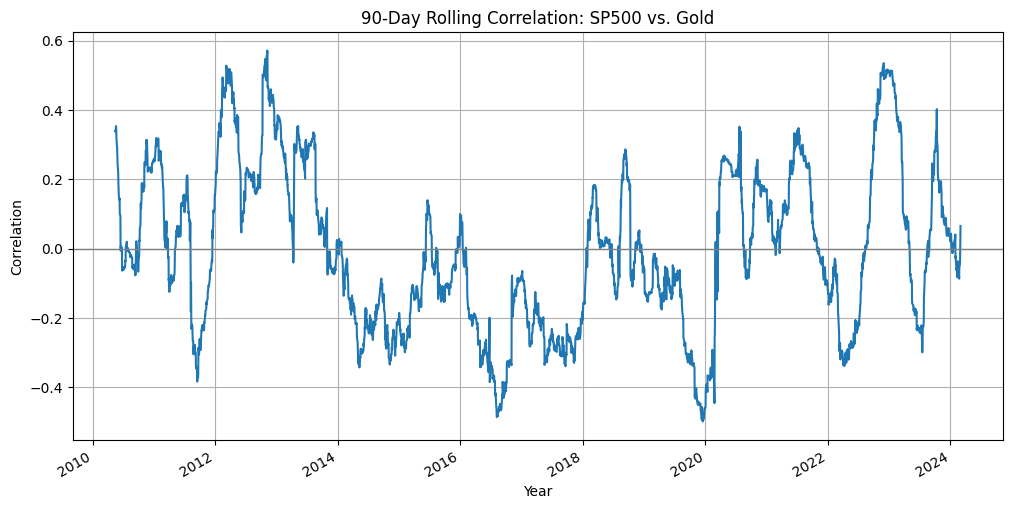

In [43]:
# Cell 7: Rolling Correlation between SP500 and Crude Oil (90-day rolling window)
import matplotlib.pyplot as plt

rolling_corr = returns['SP500'].rolling(window=90).corr(returns['Gold'])

rolling_corr.plot(figsize=(12, 6), title='90-Day Rolling Correlation: SP500 vs. Gold')
plt.axhline(0, color='grey', lw=1)
plt.xlabel('Year')
plt.ylabel('Correlation')
plt.grid(True)
plt.show()


In [44]:
# Cell 7: Granger Causality Analysis (Do commodities lead equities or vice versa?)
from statsmodels.tsa.stattools import grangercausalitytests

test_result = grangercausalitytests(returns[['SP500', 'Gold']].dropna(), maxlag=10)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.1345  , p=0.1441  , df_denom=3547, df_num=1
ssr based chi2 test:   chi2=2.1363  , p=0.1438  , df=1
likelihood ratio test: chi2=2.1357  , p=0.1439  , df=1
parameter F test:         F=2.1345  , p=0.1441  , df_denom=3547, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=5.4418  , p=0.0044  , df_denom=3544, df_num=2
ssr based chi2 test:   chi2=10.8989 , p=0.0043  , df=2
likelihood ratio test: chi2=10.8822 , p=0.0043  , df=2
parameter F test:         F=5.4418  , p=0.0044  , df_denom=3544, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=3.7041  , p=0.0112  , df_denom=3541, df_num=3
ssr based chi2 test:   chi2=11.1342 , p=0.0110  , df=3
likelihood ratio test: chi2=11.1168 , p=0.0111  , df=3
parameter F test:         F=3.7041  , p=0.0112  , df_denom=3541, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=3.2107  , p=0.

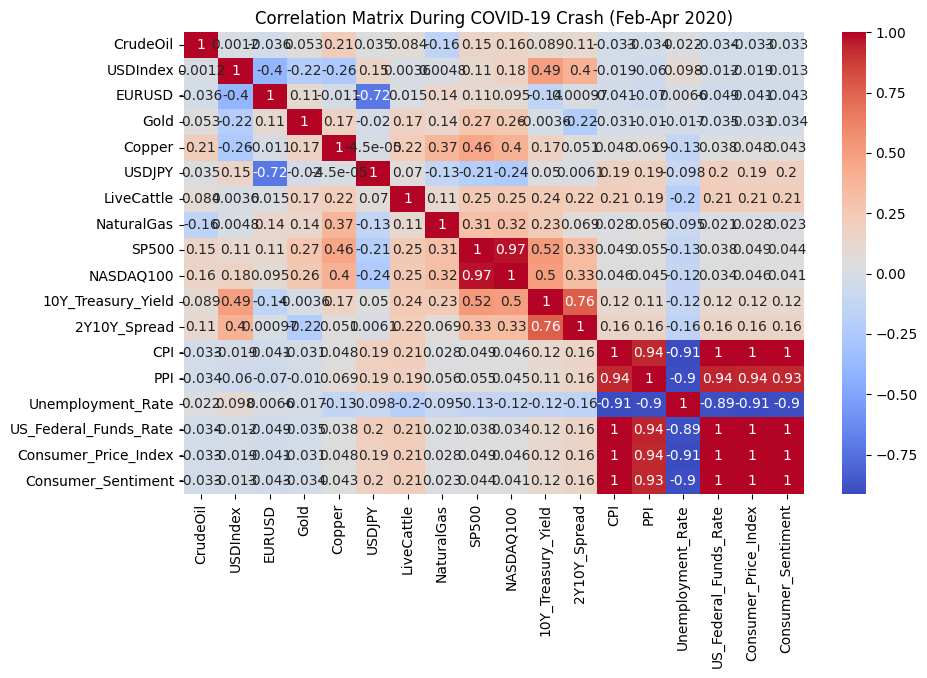

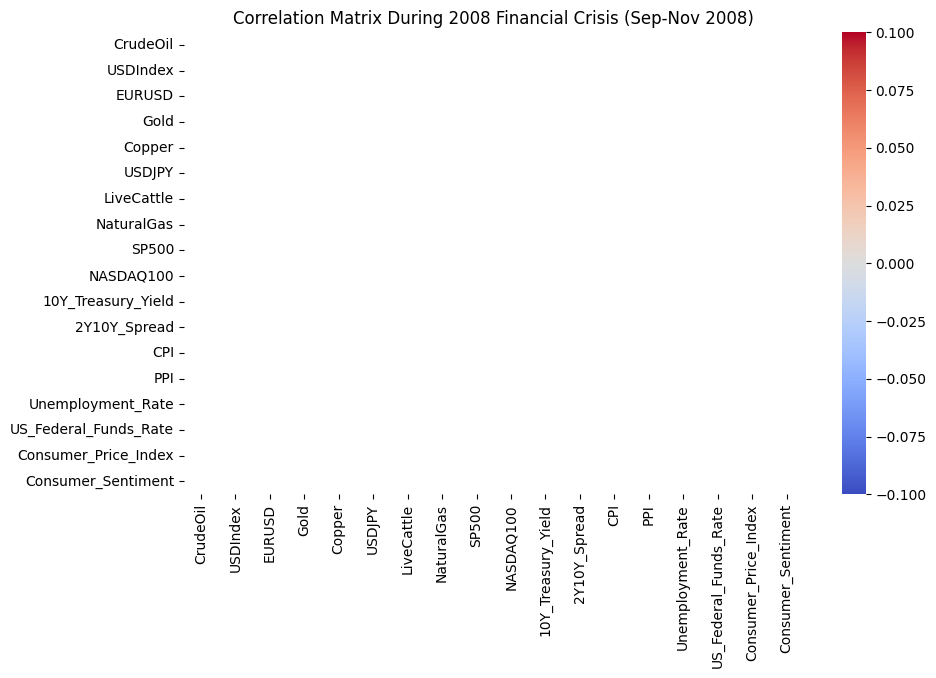

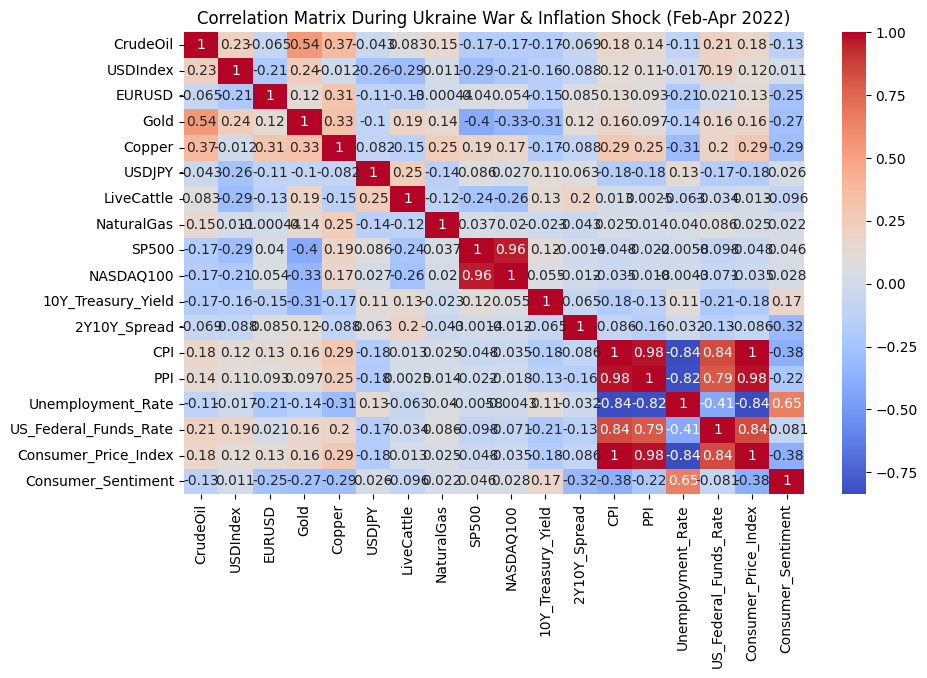

In [45]:
# Cell 8: Scenario Analysis – Major Market Stress Events
import seaborn as sns
import matplotlib.pyplot as plt

scenarios = {
    'COVID-19 Crash (Feb-Apr 2020)': returns.loc['2020-02':'2020-04'],
    '2008 Financial Crisis (Sep-Nov 2008)': returns.loc['2008-09':'2008-11'],
    'Ukraine War & Inflation Shock (Feb-Apr 2022)': returns.loc['2022-02':'2022-04']
}

for scenario_name, scenario_data in scenarios.items():
    scenario_corr = scenario_data.corr()
    plt.figure(figsize=(10,6))
    sns.heatmap(scenario_corr, annot=True, cmap='coolwarm')
    plt.title(f'Correlation Matrix During {scenario_name}')
    plt.show()


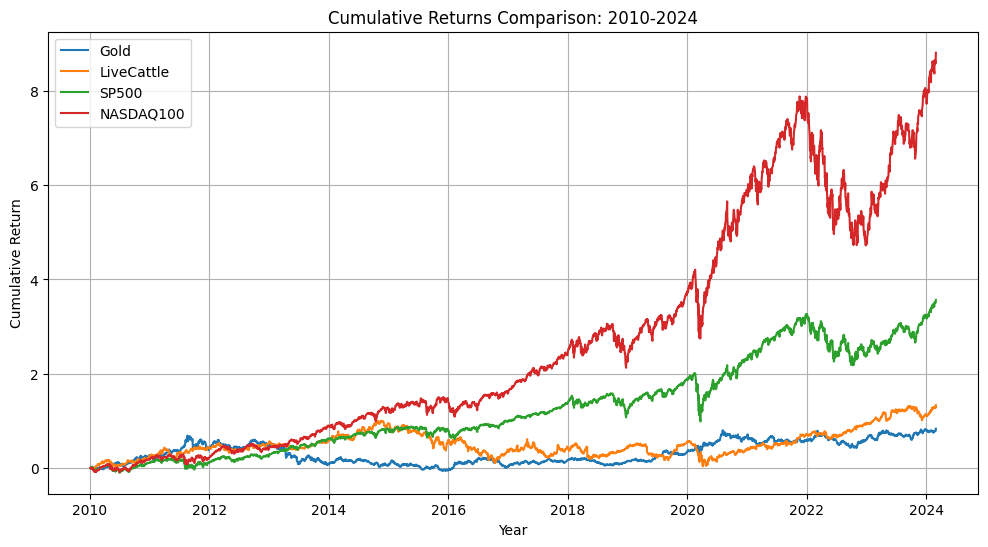

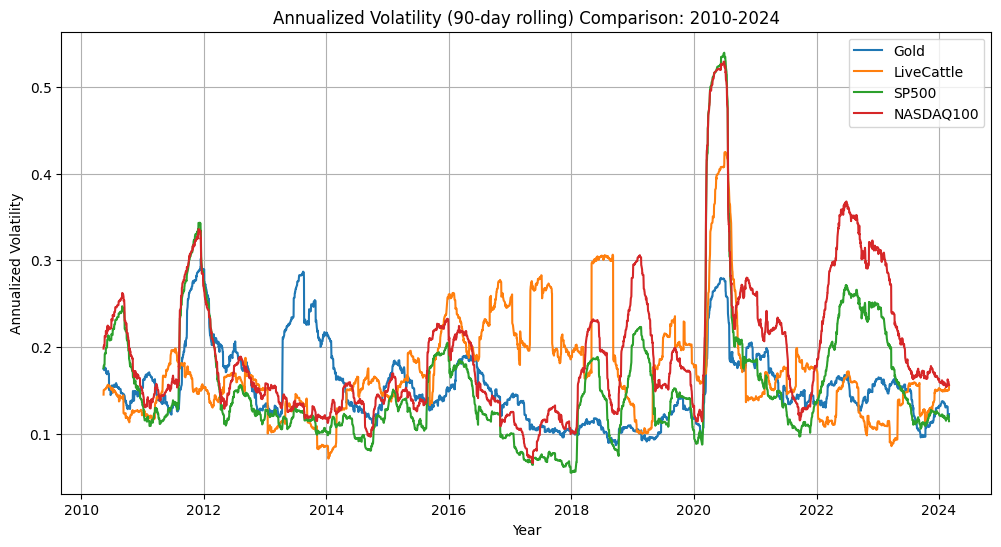

In [46]:
# Cell 9: Comparative Analysis of Returns and Volatility
import matplotlib.pyplot as plt

# Select relevant assets
assets = ['Gold', 'LiveCattle', 'SP500', 'NASDAQ100']

# Calculate cumulative returns clearly
cumulative_returns = (1 + returns[assets]).cumprod() - 1

# Calculate rolling volatility (90-day annualized volatility)
rolling_volatility = returns[assets].rolling(window=90).std() * np.sqrt(252)

# Plot cumulative returns
plt.figure(figsize=(12, 6))
for asset in assets:
    plt.plot(cumulative_returns.index, cumulative_returns[asset], label=asset)

plt.title('Cumulative Returns Comparison: 2010-2024')
plt.xlabel('Year')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True)
plt.show()

# Plot volatility clearly
plt.figure(figsize=(12, 6))
for asset in assets:
    plt.plot(rolling_vol := returns[asset].rolling(window=90).std() * np.sqrt(252), label=asset)

plt.title('Annualized Volatility (90-day rolling) Comparison: 2010-2024')
plt.xlabel('Year')
plt.ylabel('Annualized Volatility')
plt.legend()
plt.grid(True)
plt.show()


In [47]:
# Multivariate Regression Analysis: Macroeconomic indicators vs. Equity Returns
import statsmodels.api as sm

# Define your predictors (macroeconomic indicators)
macro_vars = ['10Y_Treasury_Yield', '2Y10Y_Spread', 'Unemployment_Rate', 'CPI', 'Consumer_Sentiment']

# Target variable clearly defined (SP500 returns)
X_macro = data[macro_vars]
y_sp500 = data['SP500']

X_macro = sm.add_constant(X_macro)
macro_model = sm.OLS(y_sp500, X_macro).fit()

# Display clear, structured summary
print(macro_model.summary())


                            OLS Regression Results                            
Dep. Variable:                  SP500   R-squared:                       0.959
Model:                            OLS   Adj. R-squared:                  0.959
Method:                 Least Squares   F-statistic:                 1.674e+04
Date:                Mon, 17 Mar 2025   Prob (F-statistic):               0.00
Time:                        17:55:57   Log-Likelihood:                -24219.
No. Observations:                3553   AIC:                         4.845e+04
Df Residuals:                    3547   BIC:                         4.849e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const              -1.367e+04    148

In [48]:

# Granger Causality Tests: Macro variables and SP500 returns
from statsmodels.tsa.stattools import grangercausalitytests

# Define variables for causality analysis
macro_vars = ['10Y_Treasury_Yield', '2Y10Y_Spread', 'Unemployment_Rate', 'CPI', 'Consumer_Sentiment']
maxlag = 10

for var in macro_vars:
    print(f"\nGranger Causality Test: Does {var} predict SP500 returns?")
    grangercausalitytests(data[['SP500', var]].dropna(), maxlag=maxlag, verbose=True)



Granger Causality Test: Does 10Y_Treasury_Yield predict SP500 returns?

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.7781  , p=0.3778  , df_denom=3549, df_num=1
ssr based chi2 test:   chi2=0.7788  , p=0.3775  , df=1
likelihood ratio test: chi2=0.7787  , p=0.3775  , df=1
parameter F test:         F=0.7781  , p=0.3778  , df_denom=3549, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.5177  , p=0.2193  , df_denom=3546, df_num=2
ssr based chi2 test:   chi2=3.0398  , p=0.2187  , df=2
likelihood ratio test: chi2=3.0385  , p=0.2189  , df=2
parameter F test:         F=1.5177  , p=0.2193  , df_denom=3546, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.9645  , p=0.4085  , df_denom=3543, df_num=3
ssr based chi2 test:   chi2=2.8991  , p=0.4074  , df=3
likelihood ratio test: chi2=2.8979  , p=0.4076  , df=3
parameter F test:         F=0.9645  , p=0.4085  , df_denom=3543, df_num=3

Granger Causali

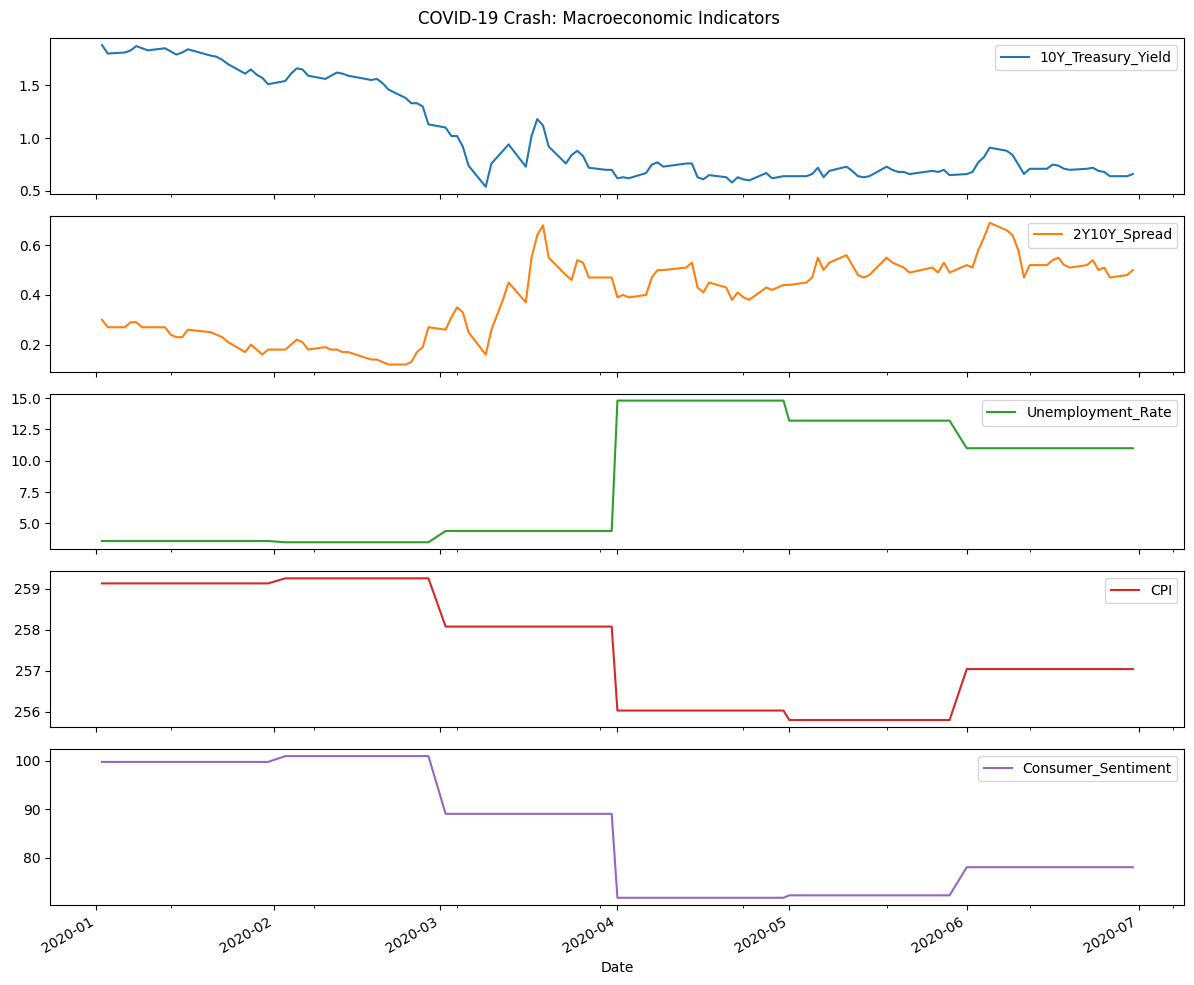

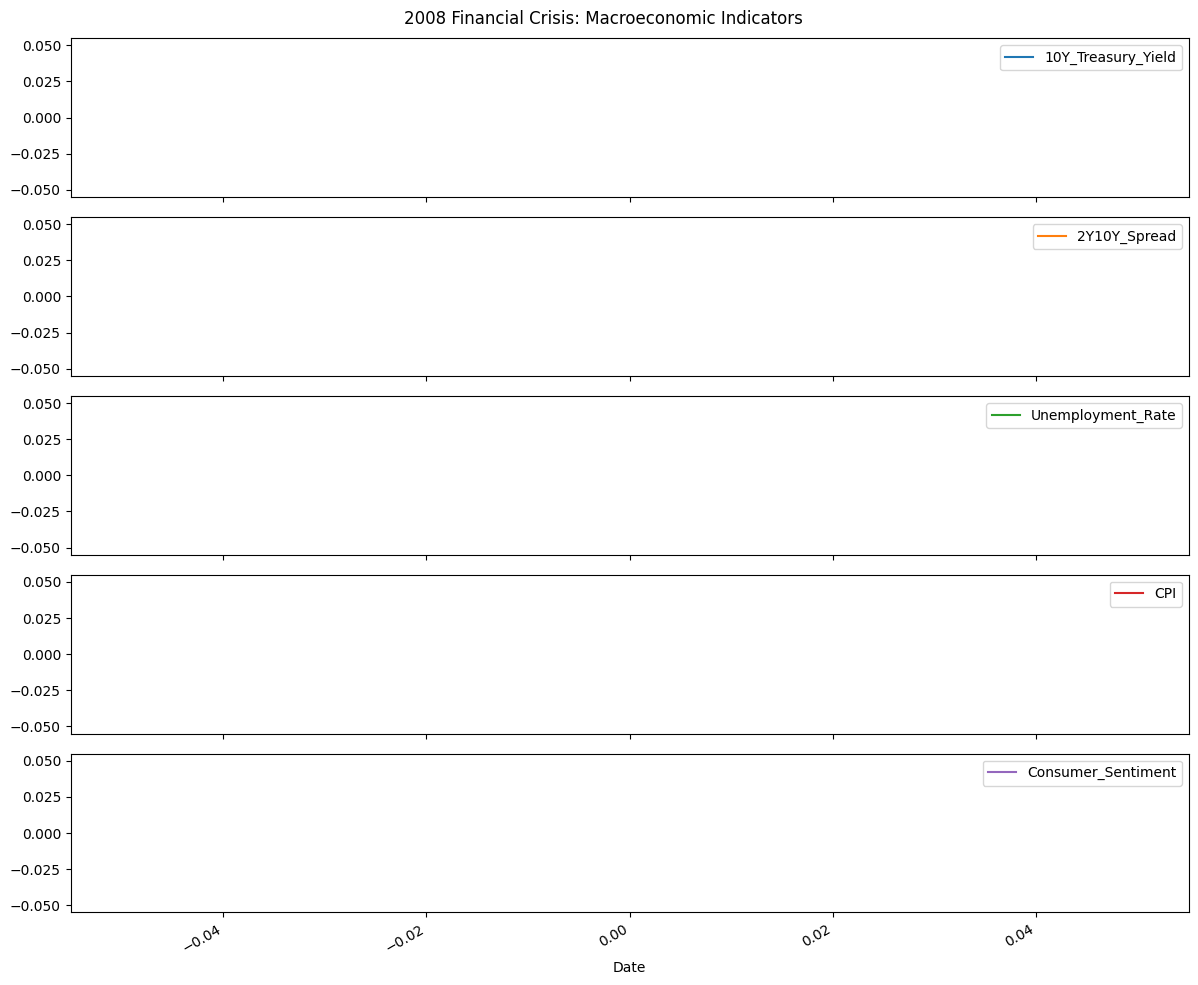

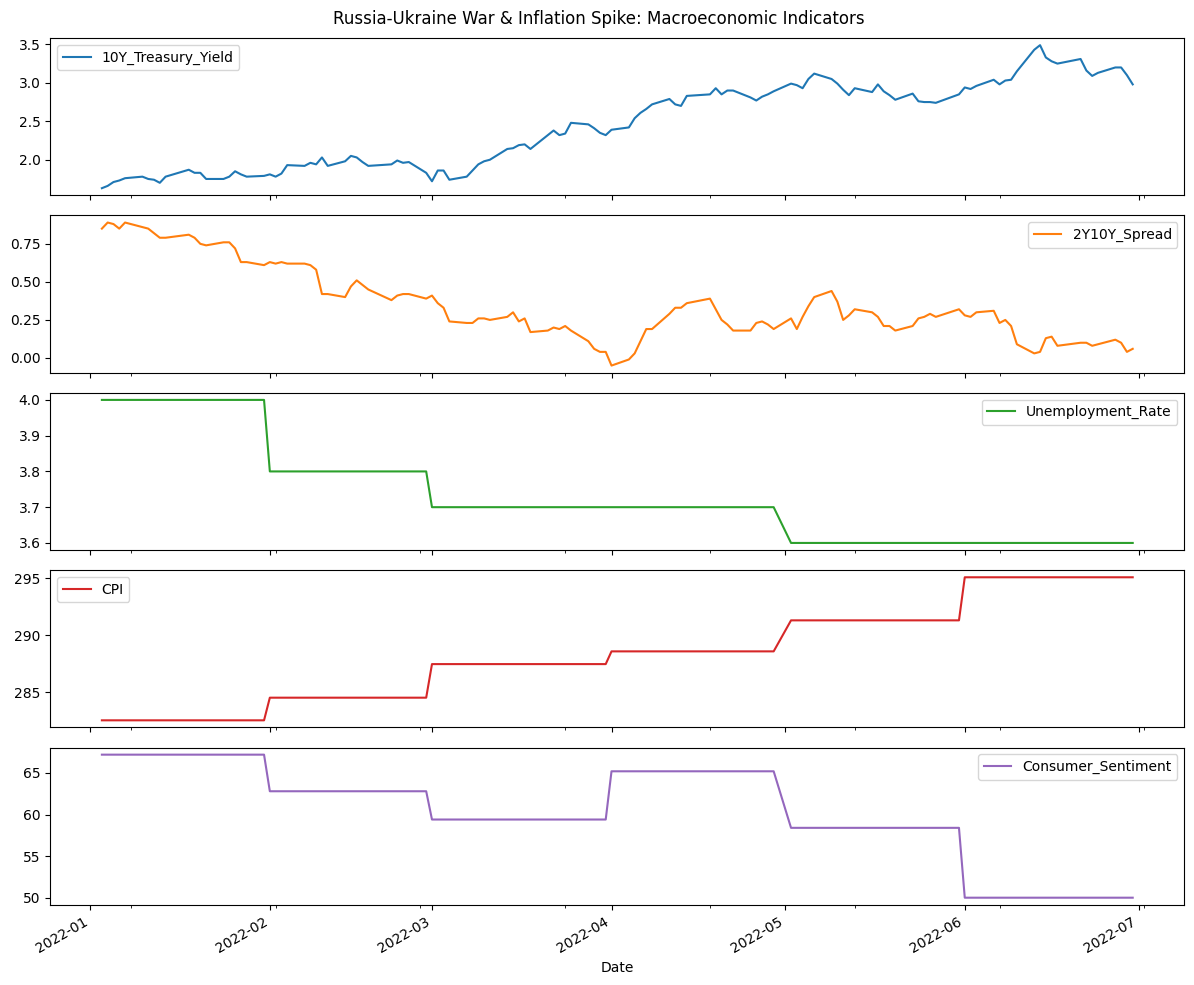

In [49]:
# Scenario Analysis: Macroeconomic Indicators During Market Stress Events
import matplotlib.pyplot as plt

# Define scenarios explicitly
scenarios = {
    'COVID-19 Crash': ('2020-01', '2020-06'),
    '2008 Financial Crisis': ('2008-07', '2009-03'),
    'Russia-Ukraine War & Inflation Spike': ('2022-01', '2022-06')
}

macro_vars = ['10Y_Treasury_Yield', '2Y10Y_Spread', 'Unemployment_Rate', 'CPI', 'Consumer_Sentiment']

for scenario, (start, end) in scenarios.items():
    scenario_data = data.loc[start:end, macro_vars]
    scenario_data.plot(subplots=True, figsize=(12, 10), title=f'{scenario}: Macroeconomic Indicators')
    plt.xlabel('Date')
    plt.tight_layout()
    plt.show()


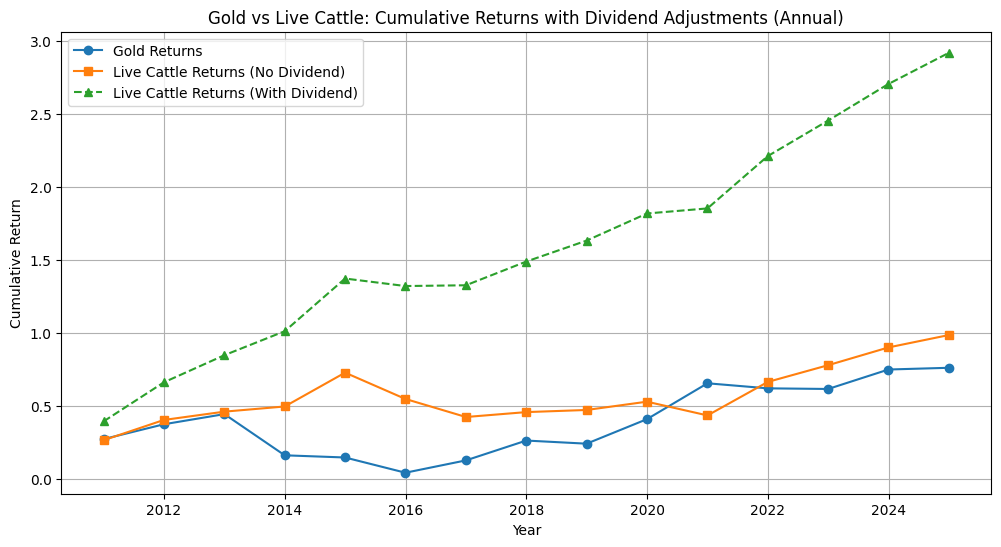

,Gold,LiveCattle,LiveCattle_DivAdj
2010-12-31,0.271450,0.263836,0.392836
2011-12-31,0.373273,0.402854,0.660854
2012-12-31,0.442886,0.459810,0.846810
2013-12-31,0.160524,0.495222,1.011222
2014-12-31,0.145548,0.727193,1.372193
2015-12-31,0.041147,0.546746,1.320746
2016-12-31,0.125745,0.423035,1.326035
2017-12-31,0.261659,0.456648,1.488648
2018-12-31,0.240224,0.471282,1.632282
2019-12-31,0.408305,0.528103,1.818103


In [51]:
# Cell: Comparative Investment Analysis – Gold vs. Cattle with Annual Dividend Yield
import matplotlib.pyplot as plt
import numpy as np

# Annual dividend yield for cattle farming (clearly calculated previously)
cattle_annual_yield = 0.129  # 12.9% annual net yield from previous calculation

# Annualize daily returns explicitly
annual_returns = returns[['Gold', 'LiveCattle']].resample('Y').apply(lambda x: (1 + x).prod() - 1)

# Clearly incorporate dividend yield explicitly into cattle returns
annual_returns_with_dividend = annual_returns.copy()
annual_returns_with_dividend['LiveCattle_DivAdj'] = annual_returns_with_dividend['LiveCattle'] +  cattle_annual_yield

# Compound returns to show cumulative performance clearly
cum_returns = (1 + annual_returns_with_dividend[['Gold', 'LiveCattle_DivAdj']]).cumprod() - 1

# Plot clearly and professionally
plt.figure(figsize=(12,6))
plt.plot(cum_returns.index, annual_returns_with_dividend['Gold'].cumsum(), marker='o', label='Gold Returns')
plt.plot(cum_returns_cattle := annual_returns_with_dividend['LiveCattle'].cumsum(), marker='s', label='Live Cattle Returns (No Dividend)')
plt.plot(cum_returns_cattle_div := annual_returns_with_dividend['LiveCattle_DivAdj'].cumsum(), marker='^', linestyle='--', label='Live Cattle Returns (With Dividend)')

plt.title('Gold vs Live Cattle: Cumulative Returns with Dividend Adjustments (Annual)')
plt.xlabel('Year')
plt.ylabel('Cumulative Return')
plt.grid(True)
plt.legend()
plt.show()

# Display cumulative returns numerically
annual_returns_with_dividend.cumsum()


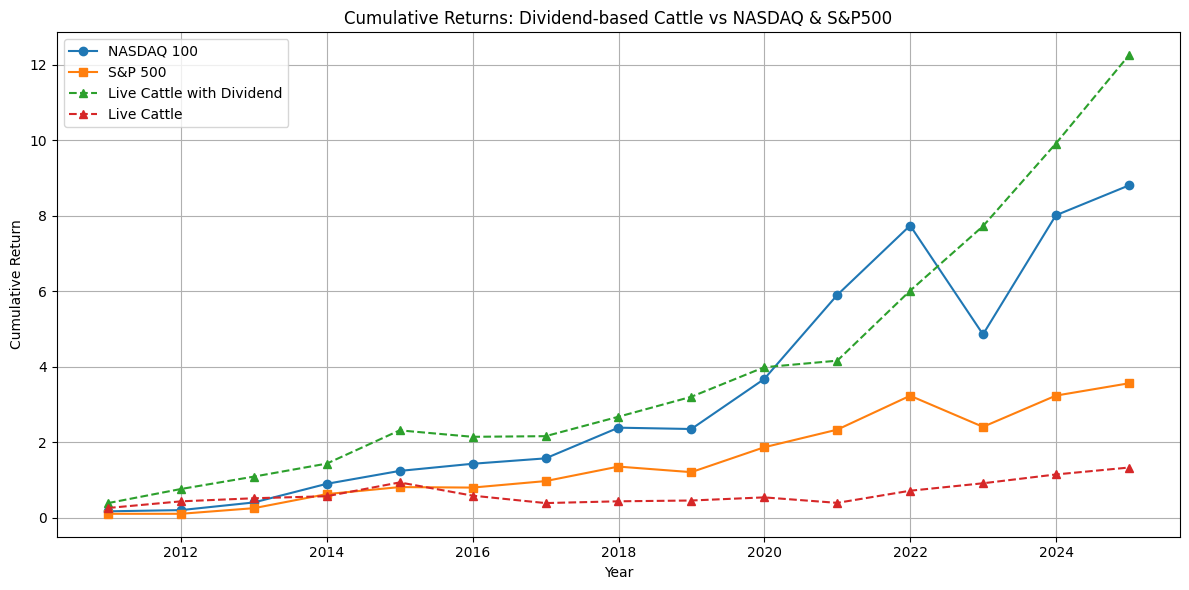

,NASDAQ100,SP500,LiveCattle,LiveCattle_DivAdj
2010-12-31,0.175523,0.110019,0.263836,0.392836
2011-12-31,0.207309,0.109983,0.439531,0.766141
2012-12-31,0.410362,0.258784,0.521523,1.094566
2013-12-31,0.903853,0.631400,0.575403,1.438938
2014-12-31,1.245338,0.817227,0.940849,2.319322
2015-12-31,1.434552,0.804023,0.590630,2.148555
2016-12-31,1.577845,0.976037,0.393851,2.165206
2017-12-31,2.390269,1.359783,0.440703,2.679911
2018-12-31,2.355049,1.212597,0.461786,3.208472
2019-12-31,3.678324,1.871362,0.544846,3.990493


In [55]:
# Cell: Dividend-Based Cattle Investment vs. SP500 & NASDAQ100
import matplotlib.pyplot as plt

# Previously calculated annual cattle dividend yield
cattle_yield = 0.129  # 12.9% annually

# Annualized returns for cattle and equity indices (NASDAQ100 and SP500)
annual_equity_returns = returns[['NASDAQ100', 'SP500', 'LiveCattle']].resample('Y').apply(lambda x: (1 + x).prod() - 1)

# Explicitly add dividend yield to Live Cattle returns
annual_equity_returns['LiveCattle_DivAdj'] = annual_equity_returns['LiveCattle'] + cattle_yield

# Calculate cumulative returns explicitly
cumulative_returns = (1 + annual_equity_returns[['NASDAQ100', 'SP500','LiveCattle', 'LiveCattle_DivAdj']]).cumprod() - 1

# Clearly visualize cumulative returns over the period explicitly
plt.figure(figsize=(12,6))
plt.plot(cumulative_returns.index, cumulative_returns['NASDAQ100'], marker='o', label='NASDAQ 100')
plt.plot(cumulative_returns.index, cumulative_returns['SP500'], marker='s', label='S&P 500')
plt.plot(cumulative_returns.index, cumulative_returns['LiveCattle_DivAdj'], marker='^', linestyle='--', label='Live Cattle with Dividend')
plt.plot(cumulative_returns.index, cumulative_returns['LiveCattle'], marker='^', linestyle='--', label='Live Cattle')

plt.title('Cumulative Returns: Dividend-based Cattle vs NASDAQ & S&P500')
plt.xlabel('Year')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Clearly display cumulative returns numerically
cumulative_returns


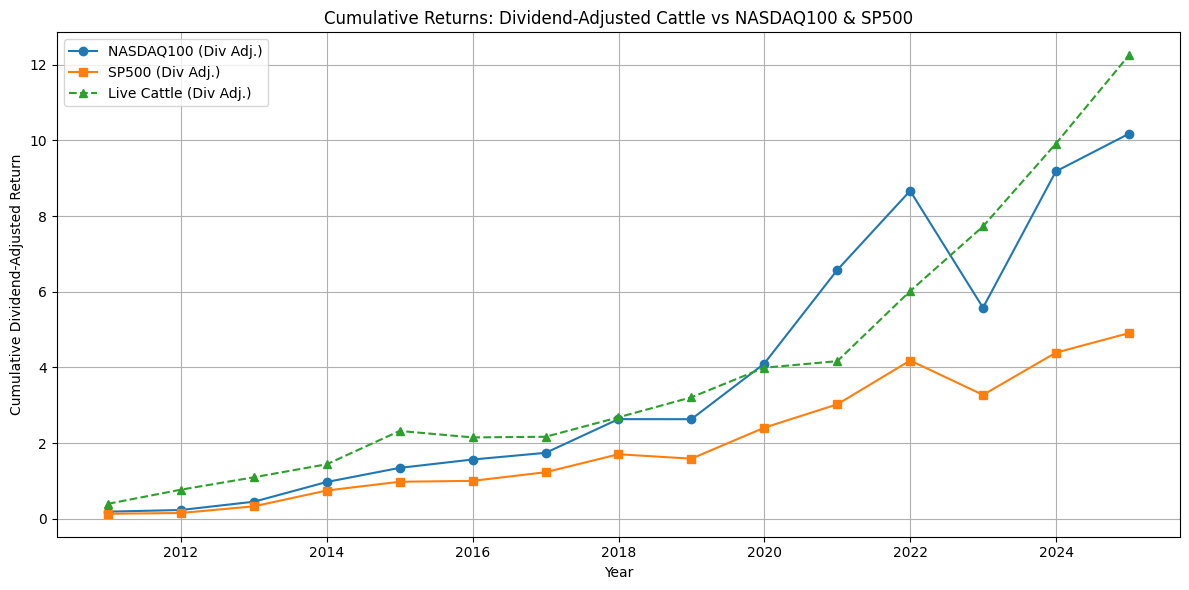

,NASDAQ100_DivAdj,SP500_DivAdj,LiveCattle_DivAdj
2010-12-31,0.185523,0.129019,0.392836
2011-12-31,0.229435,0.150434,0.766141
2012-12-31,0.448503,0.326516,1.094566
2013-12-31,0.969825,0.744385,1.438938
2014-12-31,1.342842,0.976225,2.319322
2015-12-31,1.563701,0.999414,2.148555
2016-12-31,1.740232,1.228047,2.165206
2017-12-31,2.631235,1.703066,2.679911
2018-12-31,2.629824,1.585827,3.208472
2019-12-31,4.097772,2.404846,3.990493


In [56]:
# Enhanced Cell: Dividend-Adjusted Returns Comparison (NASDAQ, S&P500, Cattle)
import matplotlib.pyplot as plt

# Annual dividend yields
cattle_yield = 0.129          # Cattle dividend yield (~12.9%)
sp500_div_yield = 0.019       # S&P 500 dividend yield (~1.9%)
nasdaq_div_yield = 0.01       # NASDAQ100 dividend yield (~1.0%)

# Compute annual returns explicitly
annual_equity_returns = returns[['NASDAQ100', 'SP500', 'LiveCattle']].resample('Y').apply(lambda x: (1 + x).prod() - 1)

# Explicitly add dividends to annual returns
annual_equity_returns['NASDAQ100_DivAdj'] = annual_equity_returns['NASDAQ100'] + nasdaq_div_yield
annual_equity_returns['SP500_DivAdj'] = annual_equity_returns['SP500'] + sp500_div_yield
annual_equity_returns['LiveCattle_DivAdj'] = annual_equity_returns['LiveCattle'] + cattle_yield

# Calculate cumulative returns explicitly
cumulative_div_adj_returns = (1 + annual_equity_returns[['NASDAQ100_DivAdj', 'SP500_DivAdj', 'LiveCattle_DivAdj']]).cumprod() - 1

# Visualize dividend-adjusted cumulative returns explicitly
plt.figure(figsize=(12, 6))
plt.plot(cumulative_div_adj_returns.index, cumulative_div_adj_returns['NASDAQ100_DivAdj'], marker='o', label='NASDAQ100 (Div Adj.)')
plt.plot(cumulative_div_adj_returns.index, cumulative_div_adj_returns['SP500_DivAdj'], marker='s', label='SP500 (Div Adj.)')
plt.plot(cumulative_div_adj_returns.index, cumulative_div_adj_returns['LiveCattle_DivAdj'], marker='^', linestyle='--', label='Live Cattle (Div Adj.)')

plt.title('Cumulative Returns: Dividend-Adjusted Cattle vs NASDAQ100 & SP500')
plt.xlabel('Year')
plt.ylabel('Cumulative Dividend-Adjusted Return')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Display dividend-adjusted cumulative returns numerically clearly
cumulative_div_adj_returns
